In [80]:
#TASK-1

In [52]:
pip install yfinance ta matplotlib seaborn pandas numpy


[*********************100%***********************]  1 of 1 completed


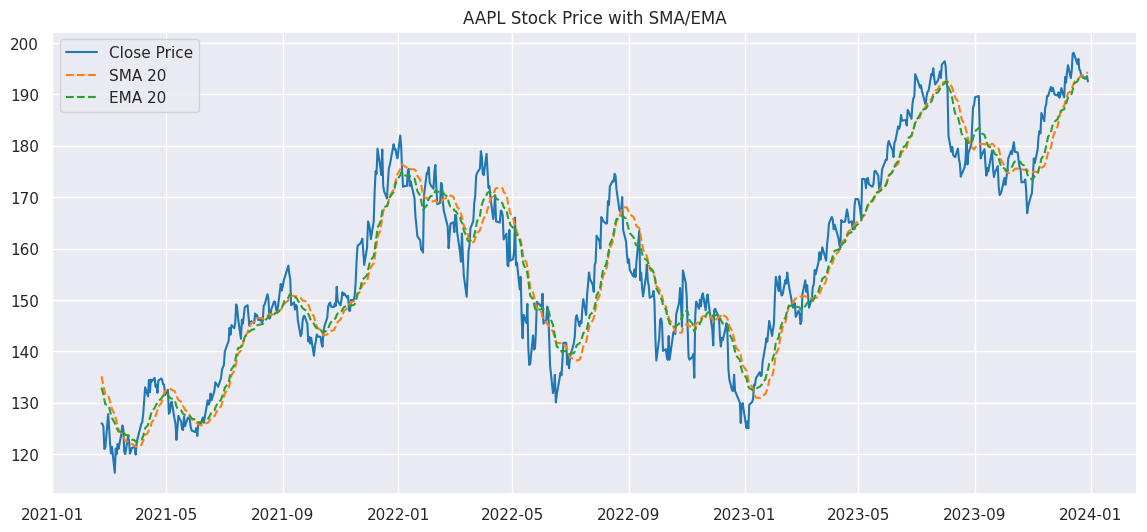

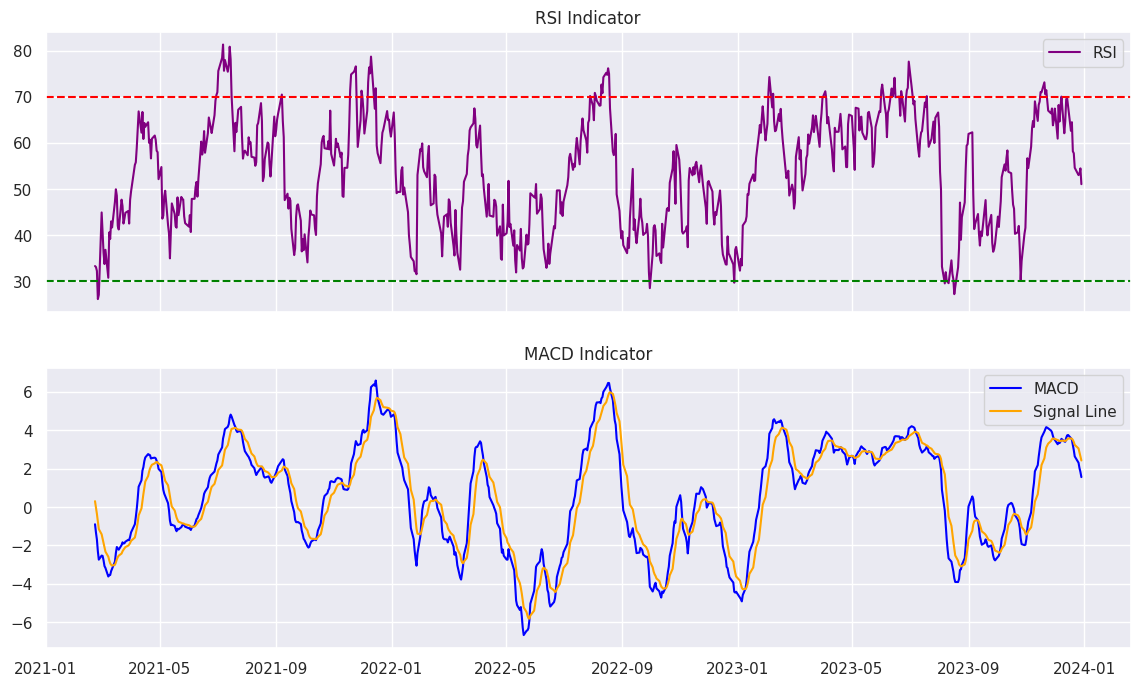

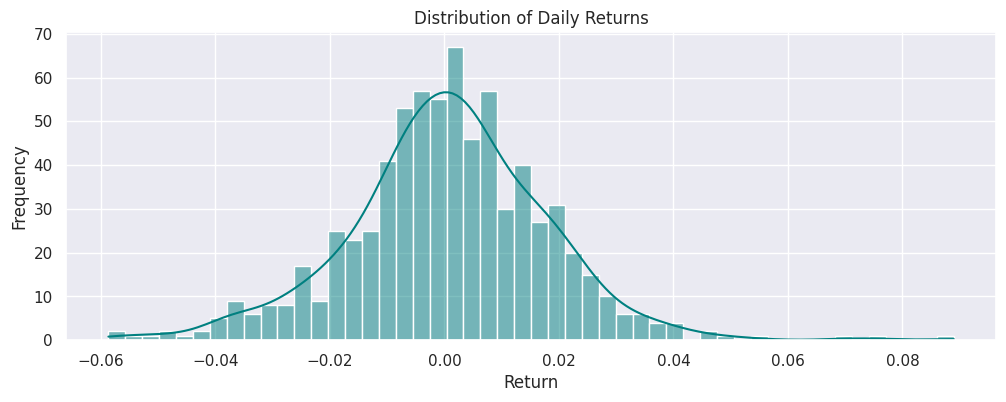

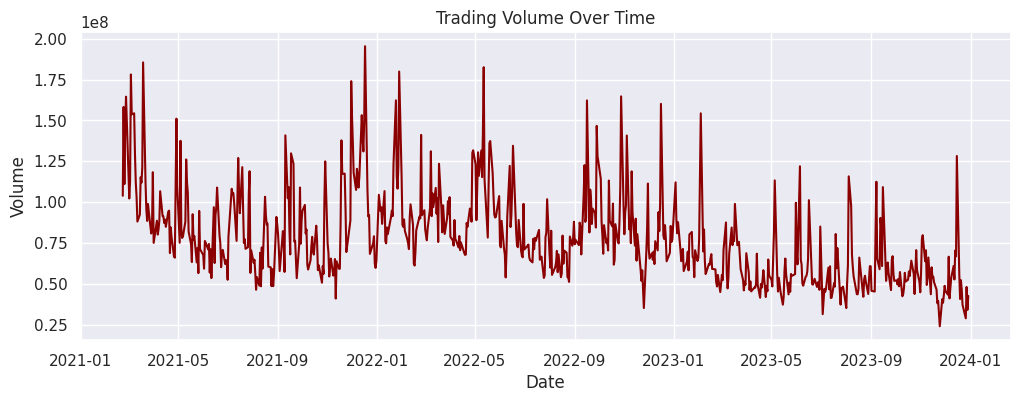

In [53]:
import pandas as pd
import numpy as np
import yfinance as yf
import matplotlib.pyplot as plt
import seaborn as sns
import ta

# Settings
sns.set_style("darkgrid")
sns.set_context("notebook")

# Step 1: Download Stock Data
ticker = "AAPL"
df = yf.download(ticker, start="2021-01-01", end="2024-01-01", auto_adjust=False)
df.dropna(inplace=True)

close = df['Close'].squeeze()
high = df['High'].squeeze()
low = df['Low'].squeeze()
volume = df['Volume'].squeeze()

# Step 2: Technical Indicators using 'ta'
df['SMA_20'] = ta.trend.SMAIndicator(close=close, window=20).sma_indicator()
df['EMA_20'] = ta.trend.EMAIndicator(close=close, window=20).ema_indicator()
df['RSI'] = ta.momentum.RSIIndicator(close=close, window=14).rsi()

macd = ta.trend.MACD(close=close)
df['MACD'] = macd.macd()
df['MACD_signal'] = macd.macd_signal()
df['MACD_diff'] = macd.macd_diff()

df['ATR'] = ta.volatility.AverageTrueRange(high=high, low=low, close=close, window=14).average_true_range()
df['OBV'] = ta.volume.OnBalanceVolumeIndicator(close=close, volume=volume).on_balance_volume()

# Step 3: Add Returns
df['Daily_Return'] = close.pct_change()
df['Log_Return'] = np.log(close / close.shift(1))

df.dropna(inplace=True)

# Step 4: Visualizations

# Plot 1: Price + SMA + EMA
plt.figure(figsize=(14, 6))
plt.plot(df.index, df['Close'], label='Close Price')
plt.plot(df.index, df['SMA_20'], label='SMA 20', linestyle='--')
plt.plot(df.index, df['EMA_20'], label='EMA 20', linestyle='--')
plt.title(f"{ticker} Stock Price with SMA/EMA")
plt.legend()
plt.show()

# Plot 2: RSI + MACD
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(14, 8), sharex=True)
ax1.plot(df.index, df['RSI'], label='RSI', color='purple')
ax1.axhline(70, color='red', linestyle='--')
ax1.axhline(30, color='green', linestyle='--')
ax1.set_title('RSI Indicator')
ax1.legend()

ax2.plot(df.index, df['MACD'], label='MACD', color='blue')
ax2.plot(df.index, df['MACD_signal'], label='Signal Line', color='orange')
ax2.set_title('MACD Indicator')
ax2.legend()
plt.show()

# Plot 3: Distribution of Returns
plt.figure(figsize=(12, 4))
sns.histplot(df['Daily_Return'], bins=50, kde=True, color='teal')
plt.title("Distribution of Daily Returns")
plt.xlabel("Return")
plt.ylabel("Frequency")
plt.show()

# Plot 4: Volume Over Time
plt.figure(figsize=(12, 4))
plt.plot(df.index, df['Volume'], color='darkred')
plt.title("Trading Volume Over Time")
plt.xlabel("Date")
plt.ylabel("Volume")
plt.show()

# Save preprocessed data
df.to_csv("AAPL_preprocessed.csv")


In [54]:
#TASK-2


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [11:30:16] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)



Random Forest Performance:
Accuracy  : 0.4897
Precision : 0.7273
Recall    : 0.1013
F1 Score  : 0.1778
ROC AUC   : 0.6020


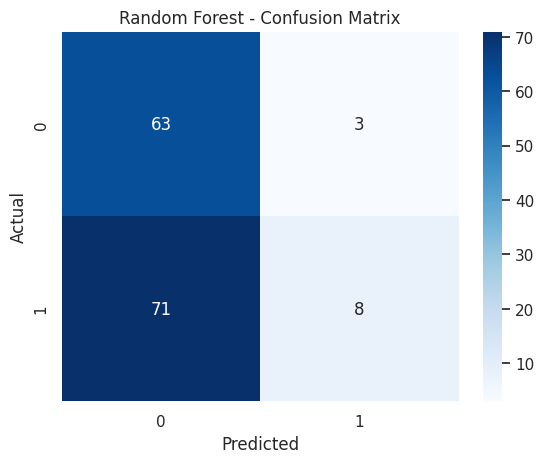

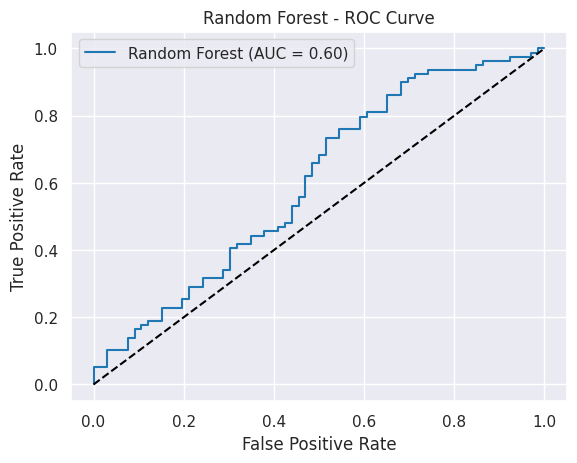


XGBoost Performance:
Accuracy  : 0.4828
Precision : 0.5833
Recall    : 0.1772
F1 Score  : 0.2718
ROC AUC   : 0.4665


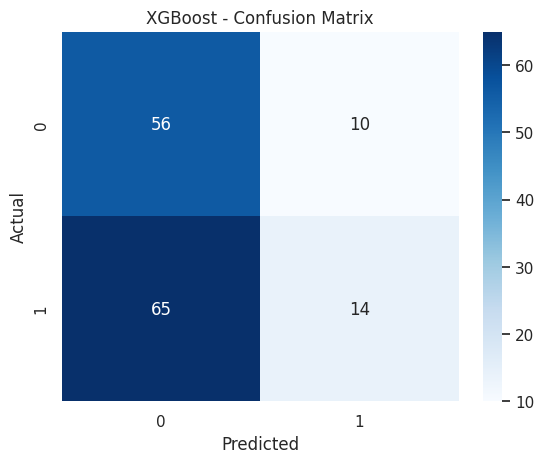

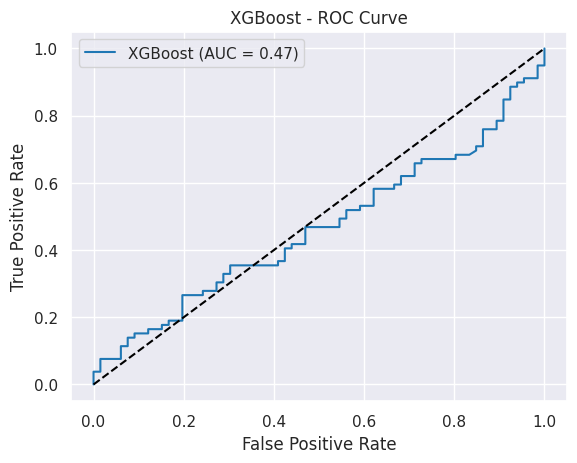

In [55]:
# Required Libraries
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, roc_auc_score, roc_curve
import matplotlib.pyplot as plt
import seaborn as sns

# Load preprocessed data (from Task 1)
df = pd.read_csv("AAPL_preprocessed.csv", index_col=0)

# Step 1: Create Binary Target
df['Target'] = np.where(df['Close'].shift(-1) > df['Close'], 1, 0)  # 1: Up, 0: Down

# Step 2: Feature Selection
features = ['SMA_20', 'EMA_20', 'RSI', 'MACD', 'MACD_signal', 'MACD_diff', 'ATR', 'OBV', 'Daily_Return', 'Log_Return']
X = df[features]
y = df['Target']

# Step 3: Train-Test Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

# Step 4: Train Models
rf_model = RandomForestClassifier(n_estimators=100, max_depth=5, random_state=42)
xgb_model = XGBClassifier(n_estimators=100, learning_rate=0.05, max_depth=5, use_label_encoder=False, eval_metric='logloss', random_state=42)

rf_model.fit(X_train, y_train)
xgb_model.fit(X_train, y_train)

# Step 5: Evaluation Function
def evaluate_model(name, model, X_test, y_test):
    y_pred = model.predict(X_test)
    y_prob = model.predict_proba(X_test)[:, 1]

    acc = accuracy_score(y_test, y_pred)
    prec = precision_score(y_test, y_pred)
    rec = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    auc = roc_auc_score(y_test, y_prob)

    print(f"\n{name} Performance:")
    print(f"Accuracy  : {acc:.4f}")
    print(f"Precision : {prec:.4f}")
    print(f"Recall    : {rec:.4f}")
    print(f"F1 Score  : {f1:.4f}")
    print(f"ROC AUC   : {auc:.4f}")

    cm = confusion_matrix(y_test, y_pred)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title(f"{name} - Confusion Matrix")
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.show()

    fpr, tpr, _ = roc_curve(y_test, y_prob)
    plt.plot(fpr, tpr, label=f"{name} (AUC = {auc:.2f})")
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title(f"{name} - ROC Curve")
    plt.legend()
    plt.show()

# Step 6: Evaluate Both Models
evaluate_model("Random Forest", rf_model, X_test, y_test)
evaluate_model("XGBoost", xgb_model, X_test, y_test)


In [56]:
cv_scores_rf = cross_val_score(rf_model, X, y, cv=5, scoring='accuracy')
cv_scores_xgb = cross_val_score(xgb_model, X, y, cv=5, scoring='accuracy')

print(f"\nCross-Validated Accuracy (Random Forest): {cv_scores_rf.mean():.4f}")
print(f"Cross-Validated Accuracy (XGBoost)      : {cv_scores_xgb.mean():.4f}")


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [11:30:19] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [11:30:19] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [11:30:19] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [11:30:19] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)



Cross-Validated Accuracy (Random Forest): 0.5124
Cross-Validated Accuracy (XGBoost)      : 0.5040


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [11:30:19] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


In [57]:
#TASK-3

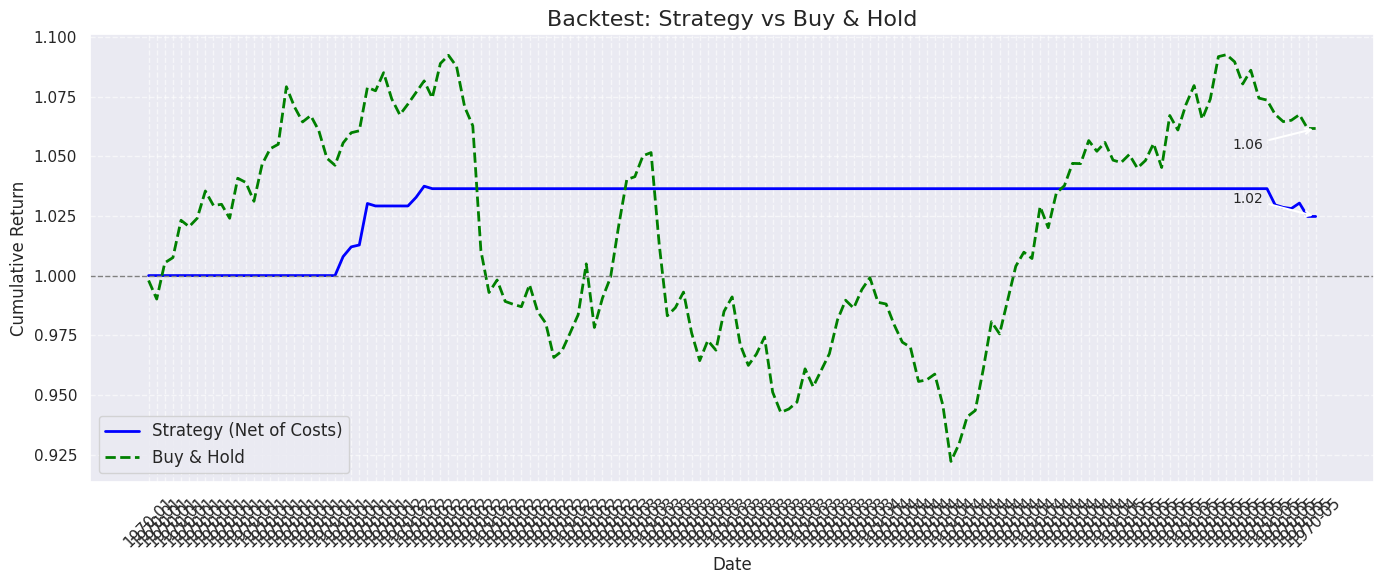

In [58]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

# Restore column names if needed
if isinstance(X_test, np.ndarray):
    X_test = pd.DataFrame(X_test, index=y_test.index, columns=X.columns)

# Get test period data and predictions
test_df = df.loc[X_test.index].copy()
test_df['Prediction'] = rf_model.predict(X_test)

# Strategy and Buy-Hold returns
test_df['Strategy_Return'] = test_df['Log_Return'].shift(-1) * test_df['Prediction']
test_df['BuyHold_Return'] = test_df['Log_Return'].shift(-1)

# Apply transaction costs
transaction_cost = 0.001  # 0.1%
test_df['Signal_Change'] = test_df['Prediction'].diff().fillna(0).abs()
test_df['Cost'] = test_df['Signal_Change'] * transaction_cost
test_df['Net_Strategy_Return'] = test_df['Strategy_Return'] - test_df['Cost']

# Cumulative performance
test_df['Cumulative_Strategy'] = (1 + test_df['Net_Strategy_Return'].fillna(0)).cumprod()
test_df['Cumulative_BuyHold'] = (1 + test_df['BuyHold_Return'].fillna(0)).cumprod()

# Plot results
plt.figure(figsize=(14, 6))
plt.plot(test_df.index, test_df['Cumulative_Strategy'], label='Strategy (Net of Costs)', color='blue', linewidth=2)
plt.plot(test_df.index, test_df['Cumulative_BuyHold'], label='Buy & Hold', color='green', linestyle='--', linewidth=2)
plt.axhline(1, color='gray', linestyle='--', linewidth=1)

plt.title("Backtest: Strategy vs Buy & Hold", fontsize=16)
plt.xlabel("Date")
plt.ylabel("Cumulative Return")
plt.legend(fontsize=12)
plt.grid(True, linestyle='--', alpha=0.6)
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
plt.xticks(rotation=45)

# Annotate final points
for col, y_offset in zip(['Cumulative_Strategy', 'Cumulative_BuyHold'], [10, -15]):
    plt.annotate(f"{test_df[col].iloc[-1]:.2f}",
                 (test_df.index[-1], test_df[col].iloc[-1]),
                 xytext=(-60, y_offset), textcoords='offset points',
                 arrowprops=dict(arrowstyle='->', lw=1.5), fontsize=10)

plt.tight_layout()
plt.show()



In [59]:
def sharpe_ratio(returns, risk_free_rate=0.0):
    excess_returns = returns - risk_free_rate
    return np.mean(excess_returns) / np.std(excess_returns) * np.sqrt(252)

def max_drawdown(cumulative_returns):
    peak = cumulative_returns.cummax()
    drawdown = (cumulative_returns - peak) / peak
    return drawdown.min()

# Compute Metrics
cum_return = test_df['Cumulative_Strategy'].iloc[-1] - 1
sharpe = sharpe_ratio(test_df['Net_Strategy_Return'].dropna())
drawdown = max_drawdown(test_df['Cumulative_Strategy'])

print(f"Cumulative Return     : {cum_return:.2%}")
print(f"Sharpe Ratio          : {sharpe:.2f}")
print(f"Maximum Drawdown      : {drawdown:.2%}")


Cumulative Return     : 2.48%
Sharpe Ratio          : 1.49
Maximum Drawdown      : -1.22%


In [60]:
#TASK-4

In [61]:
from sklearn.model_selection import GridSearchCV

param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [5, 10, 15],
    'min_samples_split': [2, 5, 10]
}

grid_search = GridSearchCV(
    estimator=RandomForestClassifier(random_state=42),
    param_grid=param_grid,
    cv=5,
    scoring='f1',  # or 'roc_auc'
    n_jobs=-1,
    verbose=1
)

grid_search.fit(X_train, y_train)

print("Best Parameters:", grid_search.best_params_)
best_model = grid_search.best_estimator_


Fitting 5 folds for each of 27 candidates, totalling 135 fits
Best Parameters: {'max_depth': 5, 'min_samples_split': 2, 'n_estimators': 100}


In [62]:
y_pred_opt = best_model.predict(X_test)
print("Accuracy :", accuracy_score(y_test, y_pred_opt))
print("Precision:", precision_score(y_test, y_pred_opt))
print("Recall   :", recall_score(y_test, y_pred_opt))
print("F1 Score :", f1_score(y_test, y_pred_opt))
print("ROC AUC  :", roc_auc_score(y_test, best_model.predict_proba(X_test)[:, 1]))


Accuracy : 0.4896551724137931
Precision: 0.7272727272727273
Recall   : 0.10126582278481013
F1 Score : 0.17777777777777778
ROC AUC  : 0.6020329881089375


In [63]:
tp_threshold = 0.02  # Take profit at +2%
sl_threshold = -0.01  # Stop loss at -1%

# Shift log returns to simulate next-day
next_returns = df['Log_Return'].shift(-1)

# Create new strategy returns with TP/SL logic
strategy_returns = []
for i in X_test.index:
    pred = best_model.predict(X_test.loc[[i]])[0]
    if pred == 1:
        r = next_returns.loc[i]
        if pd.isna(r):
            strategy_returns.append(0)
        elif r >= tp_threshold:
            strategy_returns.append(tp_threshold)
        elif r <= sl_threshold:
            strategy_returns.append(sl_threshold)
        else:
            strategy_returns.append(r)
    else:
        strategy_returns.append(0)

# Rebuild strategy DataFrame
test_df['RiskManaged_Return'] = strategy_returns
test_df['RiskManaged_Return'] = test_df['RiskManaged_Return'] - test_df['Signal_Change'] * transaction_cost
test_df['Cumulative_RiskManaged'] = (1 + test_df['RiskManaged_Return'].fillna(0)).cumprod()


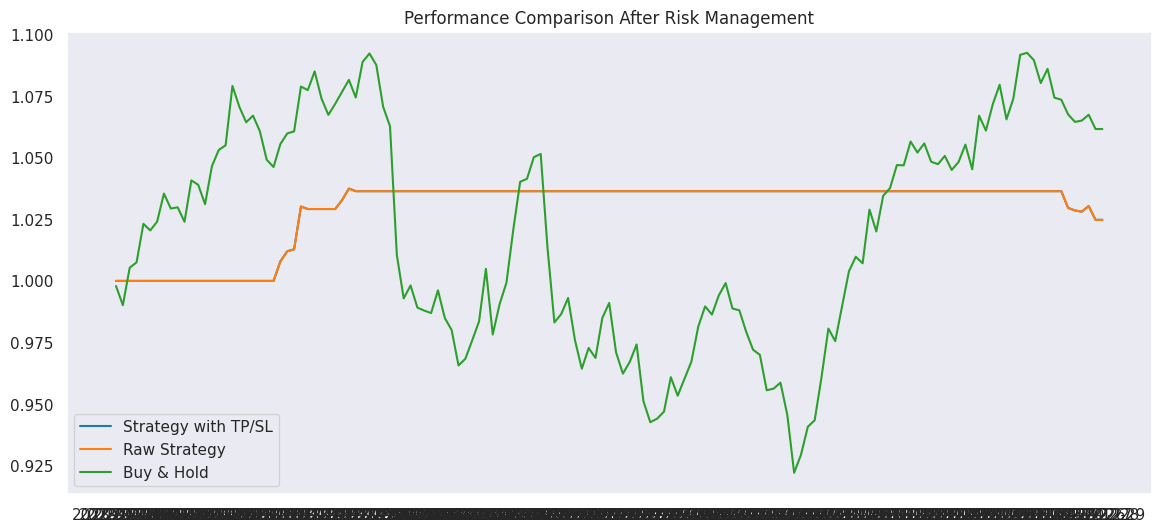

In [64]:
plt.figure(figsize=(14, 6))
plt.plot(test_df.index, test_df['Cumulative_RiskManaged'], label='Strategy with TP/SL')
plt.plot(test_df.index, test_df['Cumulative_Strategy'], label='Raw Strategy')
plt.plot(test_df.index, test_df['Cumulative_BuyHold'], label='Buy & Hold')
plt.title('Performance Comparison After Risk Management')
plt.legend()
plt.grid()
plt.show()


In [65]:
cum_return_rm = test_df['Cumulative_RiskManaged'].iloc[-1] - 1
sharpe_rm = sharpe_ratio(test_df['RiskManaged_Return'].dropna())
drawdown_rm = max_drawdown(test_df['Cumulative_RiskManaged'])

print(f"Final Cumulative Return : {cum_return_rm:.2%}")
print(f"Sharpe Ratio            : {sharpe_rm:.2f}")
print(f"Max Drawdown            : {drawdown_rm:.2%}")


Final Cumulative Return : 2.48%
Sharpe Ratio            : 1.48
Max Drawdown            : -1.22%


In [68]:
#BONUS TASK

Epoch 1/20


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


15/15 ━━━━━━━━━━━━━━━━━━━━ 3s 38ms/step - accuracy: 0.4484 - loss: 0.7015 - val_accuracy: 0.5263 - val_loss: 0.6875
Epoch 2/20
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.5403 - loss: 0.6809 - val_accuracy: 0.5263 - val_loss: 0.6852
Epoch 3/20
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.5678 - loss: 0.6818 - val_accuracy: 0.5263 - val_loss: 0.6837
Epoch 4/20
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.5394 - loss: 0.6888 - val_accuracy: 0.5088 - val_loss: 0.6839
Epoch 5/20
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.5775 - loss: 0.6804 - val_accuracy: 0.5088 - val_loss: 0.6817
Epoch 6/20
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.5465 - loss: 0.6843 - val_accuracy: 0.5175 - val_loss: 0.6834
Epoch 7/20
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.5692 - loss: 0.6857 - val_accuracy: 0.5175 - val_loss: 0.6835
Epoch 8/20
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.5882 - loss: 0.6722 - val_accuracy: 0.5439 - val_loss: 0.

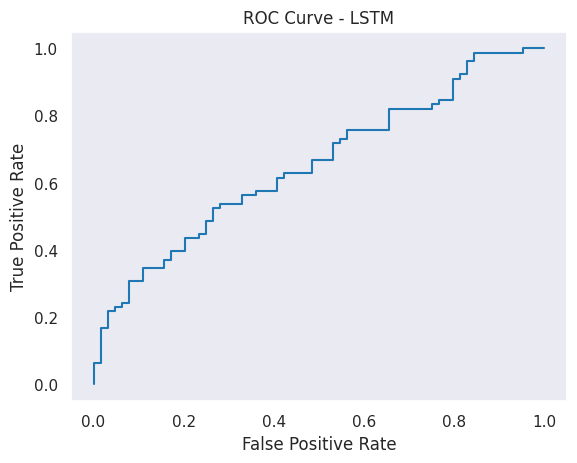

In [78]:
import tensorflow as tf
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix, roc_curve
import matplotlib.pyplot as plt

# Use same features as before
features = ['SMA_20', 'EMA_20', 'RSI', 'MACD', 'MACD_signal', 'MACD_diff', 'ATR', 'OBV']
target_col = 'Target'

# Create binary classification target
df[target_col] = (df['Daily_Return'].shift(-1) > 0).astype(int)
df.dropna(inplace=True)

# Normalize features
scaler = StandardScaler()
scaled_features = scaler.fit_transform(df[features])
scaled_df = pd.DataFrame(scaled_features, index=df.index, columns=features)
scaled_df[target_col] = df[target_col]

# Prepare sequences
sequence_length = 10
X, y = [], []
for i in range(len(scaled_df) - sequence_length):
    X.append(scaled_df.iloc[i:i+sequence_length][features].values)
    y.append(scaled_df.iloc[i+sequence_length][target_col])
X, y = np.array(X), np.array(y)

# Train-test split (time-based)
split = int(len(X) * 0.8)
X_train, X_test = X[:split], X[split:]
y_train, y_test = y[:split], y[split:]

# Build LSTM model
model = tf.keras.Sequential([
    tf.keras.layers.LSTM(64, input_shape=(X.shape[1], X.shape[2]), return_sequences=False),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
history = model.fit(X_train, y_train, epochs=20, batch_size=32, validation_split=0.2, verbose=1)

# Predict
y_pred_prob = model.predict(X_test).flatten()
y_pred = (y_pred_prob > 0.5).astype(int)

# Evaluate
print("Accuracy :", accuracy_score(y_test, y_pred))
print("Precision:", precision_score(y_test, y_pred))
print("Recall   :", recall_score(y_test, y_pred))
print("F1 Score :", f1_score(y_test, y_pred))
print("ROC AUC  :", roc_auc_score(y_test, y_pred_prob))

# Optional: ROC Curve
fpr, tpr, _ = roc_curve(y_test, y_pred_prob)
plt.plot(fpr, tpr)
plt.title("ROC Curve - LSTM")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.grid()
plt.show()


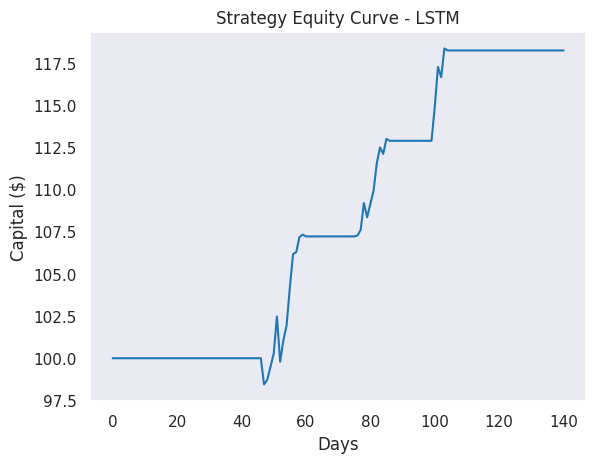

Final Cumulative Return : 18.25%
Sharpe Ratio            : 3.50
Max Drawdown            : -2.62%


In [79]:
# Create a DataFrame to align predictions with actual price data
test_dates = df.iloc[-len(y_test):].index[-len(y_pred):]  # ensure alignment
backtest_df = pd.DataFrame({
    'Close': df.loc[test_dates, 'Close'].values,
    'Daily_Return': df.loc[test_dates, 'Daily_Return'].values,
    'Prediction': y_pred
}, index=test_dates)

# Initialize strategy logic
initial_capital = 100
position = 0  # 1 if holding stock, 0 if in cash
capital = initial_capital
capital_curve = []

transaction_cost = 0.001  # 0.1%

for i in range(len(backtest_df) - 1):
    row = backtest_df.iloc[i]
    next_return = backtest_df.iloc[i + 1]['Daily_Return']
    pred = row['Prediction']

    # Trading strategy:
    if pred == 1:
        if position == 0:
            capital *= (1 - transaction_cost)  # Buy
            position = 1
    else:
        if position == 1:
            capital *= (1 - transaction_cost)  # Sell
            position = 0

    # If holding, apply return
    if position == 1:
        capital *= (1 + next_return)

    capital_curve.append(capital)

# Final capital and returns
final_capital = capital
cumulative_return = (final_capital / initial_capital - 1) * 100

# Calculate Sharpe Ratio and Max Drawdown
capital_curve = np.array(capital_curve)
returns = np.diff(capital_curve) / capital_curve[:-1]
sharpe_ratio = np.mean(returns) / np.std(returns) * np.sqrt(252) if np.std(returns) != 0 else 0

# Max Drawdown
rolling_max = np.maximum.accumulate(capital_curve)
drawdowns = (capital_curve - rolling_max) / rolling_max
max_drawdown = drawdowns.min() * 100  # in %

# Plot equity curve
plt.plot(capital_curve)
plt.title("Strategy Equity Curve - LSTM")
plt.ylabel("Capital ($)")
plt.xlabel("Days")
plt.grid()
plt.show()

# Print performance
print(f"Final Cumulative Return : {cumulative_return:.2f}%")
print(f"Sharpe Ratio            : {sharpe_ratio:.2f}")
print(f"Max Drawdown            : {max_drawdown:.2f}%")
